In [1]:
import requests
import json
import torch
import torch.nn as nn
import os
from tqdm import tqdm
from transformers import BertModel, BertTokenizerFast, AdamW
# AutoTokenizer, AutoModelForQuestionAnswering, BertTokenizer, BertForQuestionAnswering
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

2024-11-07 14:12:48.957600: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 14:12:48.971926: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731006768.988744  917203 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731006768.993792  917203 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 14:12:49.011739: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

cuda


In [2]:
def load_data_from_file(path): 
    #read each file and retrieve the contexts, qustions and answers
    with open(path, 'rb') as f:
        data_content = json.load(f)
    contexts = []
    questions = []
    answers = []
    total_questions = 0
    total_possible = 0
    total_impossible = 0
    for group in data_content['data']:
        for paragraph in group['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                question       = qa['question']
                total_questions  = total_questions  +1
                #if qa['is_impossible'] == True:
                    #total_impossible = total_impossible +1
                #else:
                    #total_possible = total_possible +1
                for answer in qa['answers']:
                    contexts.append(context.lower())
                    questions.append(question.lower())
                    answers.append(answer)
    return total_questions, total_possible, total_impossible, contexts, questions, answers

In [3]:
total_questions, total_possible, total_impossible, train_contexts, train_questions, train_answers = load_data_from_file('./spoken_train-v1.1.json')
total_questions  = total_questions
num_posible = total_possible
num_imposible  = total_impossible

total_questions, total_possible, total_impossible, valid_contexts, valid_questions, valid_answers = load_data_from_file('./spoken_test-v1.1.json')
print(len(valid_contexts))
print(len(valid_questions))
print(len(valid_answers))
def compute_answer_endpoints(answers, contexts):
    for answer, context in zip(answers, contexts):
        answer['text'] = answer['text'].lower()
        answer['answer_end'] = answer['answer_start'] + len(answer['text'])

compute_answer_endpoints(train_answers, train_contexts)
compute_answer_endpoints(valid_answers, valid_contexts)

#Text lengths to contextx
context_lengths = []

for txt in train_contexts:
    txt = txt.strip()  # remove leading and trailing whitespaces
    context_lengths.append(len(txt.split(' ')))
  

print(max(context_lengths))

15875
15875
15875
789


34
37111
['what is in front of the notre dame main building?', 'the basilica of the sacred heart at notre dame is beside to which structure?']
['architecturally the school has a catholic character. atop the main building school dome is the golden statue of the virgin mary. immediately in front of the main building in facing it is a copper statue of christ with arms appraised with the legend and the bad meow names. next to the main building is the basilica of the sacred heart. immediately behind the basilica is the grotto im mary in place of prayer and reflection. it is a replica of the grotto at lourdes france where the virgin mary reputedly appeared to st bernadette still burning eighteen fifty eight. at the end of the main drive and in a direct line that connects through three statues in the gold dome is as simple modern stone statue of mary.', 'architecturally the school has a catholic character. atop the main building school dome is the golden statue of the virgin mary. immediately

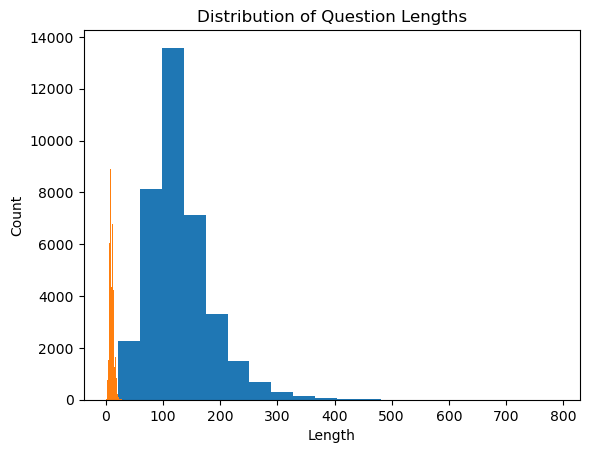

In [4]:
plt.hist(context_lengths,  bins=20)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Context Lengths');

#Test lengths of Questions
question_length_distribution = []

for txt in train_questions:
    txt = txt.strip()  # remove leading and trailing whitespaces
    question_length_distribution.append(len(txt.split(' ')))


print(max(question_length_distribution))
print(len(question_length_distribution))

plt.hist(question_length_distribution,  bins=20)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Question Lengths');

MAX_LENGTH = 250
MODEL_PATH = "deepset/bert-base-cased-squad2"

print(train_questions[0:2])
print(train_contexts[0:2])

In [5]:
tokenizerFast = BertTokenizerFast.from_pretrained(MODEL_PATH)
train_encoded_data = tokenizerFast(train_questions, train_contexts,  max_length = MAX_LENGTH, truncation=True, padding=True)
valid_encoded_data = tokenizerFast(valid_questions,valid_contexts,  max_length = MAX_LENGTH, truncation=True, padding=True)

type(train_encoded_data)

print(train_encoded_data.keys())
print(valid_encoded_data.keys())
print(len(train_encoded_data['input_ids']))
print(len(train_encoded_data['input_ids'][0]))

def compute_answer_positions_train(idx):
    ret_start = 0
    ret_end = 0
    answer_encoding_fast = tokenizerFast(train_answers[idx]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)
    for a in range( len(train_encoded_data['input_ids'][idx]) -  len(answer_encoding_fast['input_ids']) ): #len(train_encoded_data['input_ids'][0])):
        match = True
        for i in range(1,len(answer_encoding_fast['input_ids']) - 1):
            if (answer_encoding_fast['input_ids'][i] != train_encoded_data['input_ids'][idx][a + i]):
                match = False
                break
            if match:
                ret_start = a+1
                ret_end = a+i+1
                break
    return(ret_start, ret_end)

start_positions = []
end_positions = []
ctr = 0
for h in range(len(train_encoded_data['input_ids'])):
    s, e = compute_answer_positions_train(h)
    start_positions.append(s)
    end_positions.append(e)
    if s==0:
        ctr = ctr + 1

    
train_encoded_data.update({'start_positions': start_positions, 'end_positions': end_positions})
print(ctr)

def compute_answer_positions_valid(idx):
    ret_start = 0
    ret_end = 0
    answer_encoding_fast = tokenizerFast(valid_answers[idx]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)
    for a in range( len(valid_encoded_data['input_ids'][idx])  -  len(answer_encoding_fast['input_ids'])   ): #len(train_encoded_data['input_ids'][0])):
        match = True
        for i in range(1,len(answer_encoding_fast['input_ids']) - 1):
            if (answer_encoding_fast['input_ids'][i] != valid_encoded_data['input_ids'][idx][a + i]):
                match = False
                break
            if match:
                ret_start = a+1
                ret_end = a+i+1
                break
    return(ret_start, ret_end)

start_positions = []
end_positions = []
ctr = 0
for h in range(len(valid_encoded_data['input_ids']) ):
    #print(h)
    s, e = compute_answer_positions_valid(h)
    start_positions.append(s)
    end_positions.append(e)
    if s==0:
        ctr = ctr + 1

    
valid_encoded_data.update({'start_positions': start_positions, 'end_positions': end_positions})
print(ctr)

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
37111
250
507
249


In [6]:
class CustomDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, i):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][i]),
            'token_type_ids': torch.tensor(self.encodings['token_type_ids'][i]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][i]),
            'start_positions': torch.tensor(self.encodings['start_positions'][i]),
            'end_positions': torch.tensor(self.encodings['end_positions'][i])
        }
    def __len__(self):
        return len(self.encodings['input_ids'])

training_dataset = CustomDataset(train_encoded_data)
validation_dataset = CustomDataset(valid_encoded_data)

training_data_loader = DataLoader(training_dataset, batch_size=16, shuffle=True)
validation_data_loader = DataLoader(validation_dataset, batch_size=1)

bert_model = BertModel.from_pretrained(MODEL_PATH)  #MODEL_PATH = "bert-base-uncased"

In [7]:
class CustomQAModel(nn.Module):
    def __init__(self):
        super(CustomQAModel, self).__init__()
        self.bert = bert_model
        self.drop_out = nn.Dropout(0.1)
        self.l1 = nn.Linear(768 * 2, 768 * 2)
        self.l2 = nn.Linear(768 * 2, 2)
        self.linear_relu_stack = nn.Sequential(
            self.drop_out,
            self.l1,
            nn.LeakyReLU(),
            self.l2 
        )
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        model_output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, output_hidden_states=True)
        hidden_states = model_output[2]
        out = torch.cat((hidden_states[-1], hidden_states[-3]), dim=-1)  # taking Start logits from last BERT layer, End Logits from third to last layer
        logits = self.linear_relu_stack(out)
        
        start_logits, end_logits = logits.split(1, dim=-1)
        
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        return start_logits, end_logits

model = CustomQAModel()


In [8]:
def custom_loss_fn(start_logits, end_logits, start_positions, end_positions):
    loss_function = nn.CrossEntropyLoss()
    start_loss = loss_function(start_logits, start_positions)
    end_loss = loss_function(end_logits, end_positions)
    total_loss = (start_loss + end_loss)/2
    return total_loss

def custom_focal_loss_fn(start_logits, end_logits, start_positions, end_positions, gamma):
    
    #calculate Probabilities by applying Softmax to the Start and End Logits. Then get 1 - probabilities
    softmax = nn.Softmax(dim=1)
    start_probs = softmax(start_logits)
    inv_start_probs = 1 - start_probs
    end_probs = softmax(end_logits)
    inv_end_probs = 1 - end_probs
    
    #get log of probabilities. Note: NLLLoss required log probabilities. This is the Natural Log (Log base e)
    log_softmax = nn.LogSoftmax(dim=1)
    log_start_probs = log_softmax(start_logits)
    log_end_probs = log_softmax(end_logits)
    
    nll = nn.NLLLoss()
    
    focal_start_loss = nll(torch.pow(inv_start_probs, gamma)* log_start_probs, start_positions)
    focal_end_loss = nll(torch.pow(inv_end_probs, gamma)*log_end_probs, end_positions)
    
    #return mean of the Loss for the start and end logits
    return ((focal_start_loss + focal_end_loss)/2)

optim = AdamW(model.parameters(), lr=2e-5, weight_decay=2e-2)
scheduler = ExponentialLR(optim, gamma=0.9)
total_acc = []
total_loss = []


/home/tvaspar/.local/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
from evaluate import load
from sklearn.metrics import f1_score

# Load the Word Error Rate (WER) metric
wer = load("wer")

def evaluate_model(model, dataloader):
    model = model.eval()
    answer_data = []
    start_preds, end_preds = [], []
    true_starts, true_ends = [], []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Running Evaluation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            true_start_positions = batch['start_positions'].to(device)
            true_end_positions = batch['end_positions'].to(device)
            
            start_logits, end_logits = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            
            start_pred = torch.argmax(start_logits, dim=1)
            end_pred = torch.argmax(end_logits, dim=1)
            
            start_preds.extend(start_pred.cpu().tolist())
            end_preds.extend(end_pred.cpu().tolist())
            true_starts.extend(true_start_positions.cpu().tolist())
            true_ends.extend(true_end_positions.cpu().tolist())
            
            answer = tokenizerFast.convert_tokens_to_string(
                tokenizerFast.convert_ids_to_tokens(input_ids[0][start_pred[0]:end_pred[0]])
            )
            true_answer = tokenizerFast.convert_tokens_to_string(
                tokenizerFast.convert_ids_to_tokens(input_ids[0][true_start_positions[0]:true_end_positions[0]])
            )
            answer_data.append([answer, true_answer])
    
    start_f1 = f1_score(true_starts, start_preds, average='weighted')
    end_f1 = f1_score(true_ends, end_preds, average='weighted')
    overall_f1 = (start_f1 + end_f1) / 2
    return answer_data, overall_f1

In [13]:
def train_one_epoch(model, dataloader, epoch):
    model = model.train()
    losses, acc = [], []
    start_preds, end_preds = [], []
    true_starts, true_ends = [], []
    batch_tracker = 0
    
    for batch in tqdm(dataloader, desc=f'Running Epoch {epoch}'):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        
        start_logits, end_logits = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        
        loss = custom_focal_loss_fn(start_logits, end_logits, start_positions, end_positions, gamma=1)
        losses.append(loss.item())
        loss.backward()
        optim.step()
        
        start_pred = torch.argmax(start_logits, dim=1)
        end_pred = torch.argmax(end_logits, dim=1)
        
        acc.append(((start_pred == start_positions).sum() / len(start_pred)).item())
        acc.append(((end_pred == end_positions).sum() / len(end_pred)).item())
        
        start_preds.extend(start_pred.cpu().tolist())
        end_preds.extend(end_pred.cpu().tolist())
        true_starts.extend(start_positions.cpu().tolist())
        true_ends.extend(end_positions.cpu().tolist())
        
        batch_tracker += 1
        if batch_tracker == 250 and epoch == 1:
            total_acc.append(sum(acc) / len(acc))
            total_loss.append(sum(losses) / len(losses))
            batch_tracker = 0
            
    scheduler.step()
    final_accuracy = sum(acc) / len(acc)
    final_loss = sum(losses) / len(losses)
    start_f1 = f1_score(true_starts, start_preds, average='weighted')
    end_f1 = f1_score(true_ends, end_preds, average='weighted')
    overall_f1 = (start_f1 + end_f1) / 2
    return final_accuracy, final_loss, overall_f1

In [14]:
EPOCHS = 3
model.to(device)
wer_list = []

for epoch in range(EPOCHS):
    train_acc, train_loss, train_f1 = train_one_epoch(model, training_data_loader, epoch + 1)
    print(f"Train Accuracy: {train_acc}    Train Loss: {train_loss}    Train F1 Score: {train_f1}")
    
    answer_data, val_f1 = evaluate_model(model, validation_data_loader)
    predicted_answers, actual_answers = [], []
    
    for answer_pair in answer_data:
        predicted, actual = answer_pair
        predicted_answers.append(predicted if predicted else "$")
        actual_answers.append(actual if actual else "$")
    
    wer_score = wer.compute(predictions=predicted_answers, references=actual_answers)
    wer_list.append(wer_score)
    
    print(f"Validation F1 Score: {val_f1}    WER: {wer_score}")

# Tokenization example
tokens = tokenizerFast.tokenize("This is a sentence.")
print(tokens)
output_sentence = tokenizerFast.convert_tokens_to_string(tokens)
print(output_sentence)

Running Epoch 1: 100%|██████████| 2320/2320 [06:20<00:00,  6.10it/s]


Train Accuracy: 0.6665005388059493    Train Loss: 0.9425674887952106    Train F1 Score: 0.6655793848995184


Running Evaluation: 100%|██████████| 15875/15875 [01:41<00:00, 156.83it/s]


Validation F1 Score: 0.5549115001311701    WER: 2.354330708661417


Running Epoch 2: 100%|██████████| 2320/2320 [06:21<00:00,  6.07it/s]


Train Accuracy: 0.7781615609752721    Train Loss: 0.555150531906763    Train F1 Score: 0.7776823377462708


Running Evaluation: 100%|██████████| 15875/15875 [01:41<00:00, 156.37it/s]


Validation F1 Score: 0.5536174612874657    WER: 3.0418897637795275


Running Epoch 3: 100%|██████████| 2320/2320 [06:21<00:00,  6.08it/s]


Train Accuracy: 0.8483663023545824    Train Loss: 0.343052504958328    Train F1 Score: 0.8482450805817889


Running Evaluation: 100%|██████████| 15875/15875 [01:40<00:00, 157.64it/s]


Validation F1 Score: 0.5530193642022498    WER: 2.6895748031496063
['This', 'is', 'a', 'sentence', '.']
This is a sentence.
